In [10]:
import scipy
import numpy as np
from matplotlib import cm,colors, rc
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from control import dare
import single_photons.utils.constants as ct
from single_photons.utils.parameters import *
from single_photons.utils.optical_input import *
from single_photons.utils.metrics import *
from single_photons.environment import Cavity_Particle
from single_photons.simulation.simulation_cavity import simulation_c

In [2]:
import os 
os.environ["PATH"] += os.pathsep + '/usr/local/bin'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})
plt.rcParams['figure.dpi'] = 200 #600 for figure generation
C = ['#2E86C1', '#85C1E9', '#1B4F72']

In [3]:
def custom_optical_input(N, delta_t, photon_number, kappa, cavity_length, detuning, wavelength, duration):
    FSR, f, r, I_factor = compute_cavity_parameters(kappa, cavity_length, detuning, wavelength)
    amplitude = np.sqrt(photon_number * I_factor)
    optical_input = 1j*np.zeros((4,N))
    end = int(duration/delta_t)
    end = min(N,int(N/2) + end)
    s = end - int(N/2)
    optical_input[0,int(N/2):end] = np.array(s*[(np.conjugate(amplitude) + amplitude) * np.sqrt(kappa) * delta_t])
    optical_input[1,int(N/2):end] = np.array(s*[1j*(np.conjugate(amplitude) - amplitude) * np.sqrt(kappa) * delta_t])
    return FSR, f, r, I_factor, optical_input

def custom_SNR(signal,start,duration):
    ref = signal[start - duration:start]
    snr = np.mean(np.power(signal[start:start + duration],2)) / np.mean(np.power(ref,2))
    return snr

def post_process_snr(snr):
    if not np.equal(snr, None).sum():
        mean_pos = np.mean(snr)
        std_pos = np.std(snr)
    else:
        mean_pos = 0
        std_pos = 0
    return mean_pos, std_pos



In [4]:
def create_sim_elements(freq, cavity_length=0.03/1.001, 
                        cavity_linewidth=10, detuning_ratio=1, eta_detection=0.3,
                        wavelength=1064e-9, power=300e-3,
                        tweezer_waist = 3.7352e-6,
                        g_fb_ratio = 50,
                        control_delta_t=32e-9,
                        delta_t=5e-9, 
                        p = 9.2e-7, 
                        rho = 2200, 
                        index_refraction = 1.4440, 
                        T = 293, 
                        radius = 71.5e-9):
    control_step = int(control_delta_t/delta_t) 
    fs = 1/(control_step*delta_t)
    laser_linewidth = 0
    omega = 2*np.pi*freq
    period = 2*np.pi/omega
    t = np.arange(0, 300*period, delta_t)
    N = t.shape[0]
    zp_x = compute_zpx(omega, radius, rho = rho)
    cavity_linewidth = cavity_linewidth*omega
    gamma, ba_force, std_detection, std_z, g_cs, detuning =\
    compute_parameters_simulation_cavity(power, wavelength, tweezer_waist, radius, p, fs, eta_detection, 
                                        cavity_length, detuning_ratio, cavity_linewidth, omega,
                                        T = T, rho = rho, index_refraction = index_refraction)
    std_detection = std_detection/zp_x
    coupling = (1/(4*np.pi))*(ba_force**2)
    env = Cavity_Particle(
        omega,
        gamma,
        detuning,
        cavity_linewidth,
        g_cs,
        coupling,
        radius=radius,
        eta_detection=eta_detection,
        T=T,
        g_fb_ratio = g_fb_ratio
    )
    variance_process = env.thermal_force_std**2 + env.backaction_std**2
    Q = control_step*delta_t/2*np.array(
        [
            [env.__shot_std__**2, 0, 0, 0],
            [0, env.__shot_std__**2, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, variance_process]
        ])
    R = np.array([[np.power(std_detection, 2)]])
    Ad = scipy.linalg.expm(env.A *control_step*delta_t)
    Bd = env.B * delta_t * control_step
    #cov_ss = dare(Ad.T, Bd, Q, R)[0]
    cov_ss = dare(Ad, Bd, Q, R)[0]
    return (env, Ad, Bd, Q, R, 
            std_detection, cov_ss, cavity_length, 
            detuning, wavelength, eta_detection, 
            delta_t, N, control_step)


In [14]:
detunings = np.linspace(-2, 2, 20)
cavity_linewidths = np.logspace(-1,1,20)
grid_detunings, grid_linewidths = np.meshgrid(detunings, cavity_linewidths)

In [15]:
data = np.zeros(grid_detunings.shape)
numbers = np.power(np.linspace(0.1,10,3),2)
photon_number = 1

for j in tqdm(range(data.shape[1])):
    for i in range(data.shape[0]):
        if 'optical_input' in globals():
            del optical_input
        if 'new_states' in globals():
            del new_states, measured_states, estimated_states, cov_aposteriori, controls
        (env, Ad, Bd, Q, R, std_detection, cov_ss, 
        cavity_length, detuning, wavelength, 
        eta_detection, delta_t, N, control_step) = create_sim_elements(104e3, 
                                                                        detuning_ratio=grid_detunings[i,j], 
                                                                        cavity_linewidth=grid_linewidths[i,j])
        x0 = std_detection
        P0 = std_detection**2*np.eye(4)
        duration = 50e-6
        right = N/2 + duration/delta_t
        left = N/2 - duration/delta_t
        step = 40
        FSR, f, r, I_factor, optical_input = custom_optical_input(
            N, delta_t, photon_number, env.__kappa__, cavity_length, detuning, wavelength, duration)
        new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_c(
            env.A,
            env.B, 
            optical_input,
            env.thermal_force_std,
            env.backaction_std,
            env.__shot_std__,
            std_detection, 
            eta_detection,
            x0, 
            P0, 
            Ad, 
            Bd, 
            env.C, 
            env.G,
            env.G_lqr,
            Q, 
            R, 
            delta_t, 
            control_step, 
            N
        )
        
        sample = estimated_states[int(left):int(right),:].real
        cov_sample = cov_aposteriori[int(left/control_step):int(right/control_step),:,:]
        phonons = compute_phonons(sample, cov_sample, control_step, step = step)    
        SNR_phn = custom_SNR(phonons,int(duration/(step*control_step*delta_t)),int(duration/(step*control_step*delta_t)))    
        data[i,j] = SNR_phn


  0%|          | 0/20 [00:00<?, ?it/s]/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/single_photons-0.0.1-py3.8.egg/single_photons/utils/metrics.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/single_photons-0.0.1-py3.8.egg/single_photons/utils/metrics.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/single_photons-0.0.1-py3.8.egg/single_photons/utils/metrics.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/single_photons-0.0.1-py3.8.egg/single_photons/utils/metrics.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/single_photons-0.0.1-py3.8.egg/single_photons/utils/metrics.py:74: ComplexWarning: Casting complex value

In [18]:
data

array([[1.01701241, 1.34449181, 0.40243123, 1.13105856, 2.42810493,
        3.58895948, 0.93772248, 0.61566982, 1.44795091, 0.62091849,
        1.4482403 , 1.25711871, 1.3826827 , 0.8564333 , 1.32988673,
        0.81653561, 2.20341689, 1.64384442, 0.66060843, 0.46610067],
       [1.00709168, 1.27901927, 1.09083811, 1.50590292, 0.35470047,
        2.01529844, 0.64203516, 2.43163884, 1.05930344, 0.81155547,
        1.02316193, 0.89232664, 0.480475  , 1.21735109, 0.56379248,
        0.32325943, 1.24666084, 1.65026596, 1.41720142, 1.43481746],
       [1.06054202, 1.62120091, 0.92502416, 1.26336627, 2.37702249,
        0.56428292, 0.71346316, 0.78812162, 0.76532746, 1.17003194,
        1.35494026, 1.29782092, 0.88436834, 1.09164259, 1.79313524,
        1.86463623, 0.61704334, 1.79360825, 1.03938536, 1.42262304],
       [1.96010185, 1.65120601, 0.48063294, 1.56507989, 1.23461983,
        0.95128906, 2.69742152, 1.02307578, 0.85602965, 0.66474537,
        0.83281646, 0.64894714, 1.36444711, 1

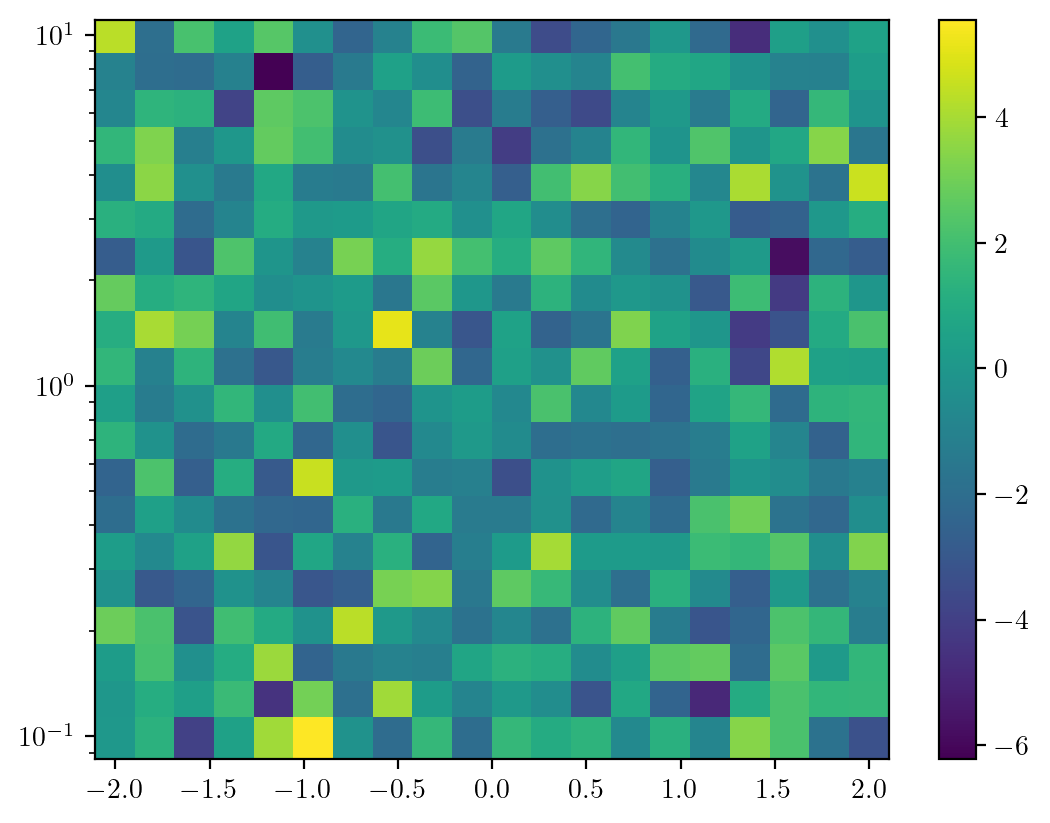

In [17]:
fig, ax = plt.subplots()
#fig.set_figwidth(6)
#fig.set_figheight(5)
#X, Z = np.meshgrid(np.linspace(-1.4e-7, 1.4e-7,200), np.linspace(-7e-7, 7e-7, 200))
p = ax.pcolor(grid_detunings, grid_linewidths, 10*np.log10(data), cmap=matplotlib.cm.viridis)
cb = fig.colorbar(p, ax=ax)
ax.set_yscale('log')
##cb.set_label(r'$V(k_B T)$', rotation=0)
##ax.set_ylabel(r'$x\,(\mu m)$')
##ax.set_xlabel(r'$z\,(\mu m)$')
#ax.set_yticks(np.arange(-0.1, 0.11, 0.1))
#ax.xaxis.labelpad = 10
#ax.yaxis.labelpad = 10
#plt.savefig('../data/plots/potential_colormap.png', dpi=300)
plt.show()

In [64]:
np.meshgrid(detunings, cavity_linewidths)

[array([[0.97, 1.  , 1.03]]), array([[0.1, 0.1, 0.1]])]

/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


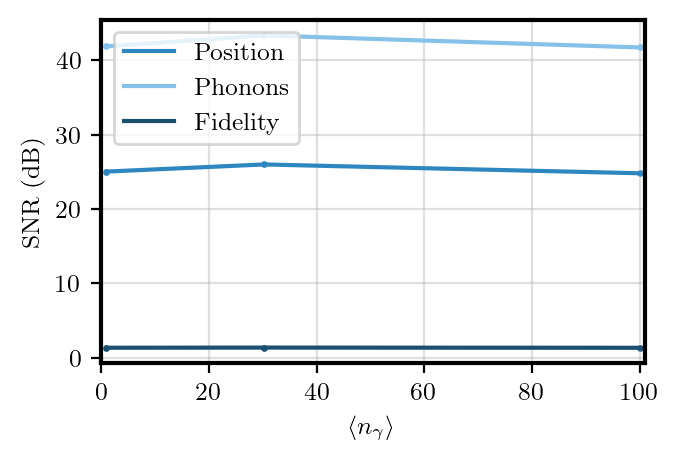

In [23]:
'''Parameters used in the last run:
delta_t = 5e-10
rho = 2200
index_refraction = 1.4440
T = 293
p = 1e-6
radius = 71.5e-9
wavelength = 1.064e-6
power = 400e-3
eta_detection = 0.178#0.178
control_step = int(30e-9/delta_t) 
fs = 1/(control_step*delta_t)
cavity_waist = 10e-6 #only affects theoretical opmech coupling
cavity_length = 0.03
tweezer_waist = 0.6e-6
detuning_ratio = 0.25 
cavity_linewidth_ratio = 0.38
optomechanical_coupling_ratio = 0.19
g_fb_ratio = 5
laser_linewidth = 0
numbers = np.power(np.linspace(1,12,40),2)
step = 40
'''
labels = ['Position', 'Phonons', 'Fidelity']
factor = 0.99
fig,ax = plt.subplots()
plt.rcParams.update({'font.size':9})
plt.rcParams['axes.linewidth'] = 1.5
fig.set_size_inches(3.5*factor, 2.4*factor, forward = True)
plt.grid(alpha = 0.4)

M = 0
for i in range(3):
    y = np.array(data.shape[0]*[None])
    x = np.array(data.shape[0]*[None])
    for j in range(data.shape[0]):
        non_null_y = []
        if np.isnan(data[j,i]):
            continue
        else:
            x[j] = numbers[j]
            y[j] = 10*np.log10(data[j,i])
            non_null_y.append(10*np.log10(data[j,i]))
        if max(non_null_y) > M:
            M = max(non_null_y)
    ax.plot(x, y, color = C[i], label = labels[i])
    ax.scatter(x, y, color = C[i], s = 2)
ymin = -0.1*M
ymax = 1.1*M
xmin = 0
xmax = numbers[-1] + numbers[0]
ax.set_xlim([xmin, xmax])
#ax.fill_between(np.array([xmin, xmax]), np.array(2*[ymin]), np.array(2*[20]), color = 'gray', alpha = 0.3)
plt.ylabel(r'SNR (dB)', fontsize = plt.rcParams['font.size'])
plt.xlabel(r'$\langle n_\gamma \rangle$', fontsize = plt.rcParams['font.size'])
plt.legend(loc = 'upper left', fontsize = plt.rcParams['font.size'])
plt.tight_layout()
#plt.savefig('SNR_measures.pdf',bbox_inches = 'tight',dpi = 600)
plt.show()

In [11]:
left = N/2 - duration/delta_t
right = N/2 + duration/delta_t
sample = estimated_states[int(left):int(right),:].real
cov_sample = cov_aposteriori[int(left/control_step):int(right/control_step),:,:]

cov_ss_1 = dare(Ad.T, Bd, Q, R)[0]
cov_ss_2 = dare(Ad,Bd,Q,R)[0]
fidelity_1 = compute_fidelity(sample,cov_sample, cov_ss_1, control_step, step=step)
fidelity_2 = compute_fidelity(sample,cov_sample, cov_ss_2, control_step, step=step)

In [13]:
SNR_1 = custom_SNR(fidelity_1,int(duration/(control_step*step*delta_t)),int(duration/(control_step*step*delta_t)))
SNR_2 = custom_SNR(fidelity_2,int(duration/(control_step*step*delta_t)),int(duration/(control_step*step*delta_t)))
print(SNR_1,SNR_2)

(0.7855607100516124-3.3029387319853142e-18j) (0.42937232633237404-1.1938535178496646e-19j)


In [25]:
zp_p = hbar/(2*zp_x)
print((env.backaction_std*zp_p)**2)
4*np.pi*coupling

2.065873021442767e-40


2.065873021442767e-40